# 10.03 - Tendencias y Patrones Temporales

**Autor:** Miguel Angel Vazquez Varela  
**Nivel:** Intermedio-Avanzado  
**Tiempo estimado:** 45 min

---

## ¿Qué aprenderás?

- `shift()` y `diff()`: lag features y tasas de cambio
- Autocorrelación: ¿se repiten los patrones?
- Descomposición estacional: tendencia + estacionalidad + residuo
- Ingeniería de características temporales para modelos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (13, 5)

In [2]:
# Dataset: 6 meses de demanda horaria con tendencia y estacionalidad realistas
np.random.seed(42)

idx = pd.date_range('2024-01-01', '2024-06-30', freq='D')

# Componentes de la serie
trend       = np.linspace(300, 500, len(idx))                    # tendencia creciente
weekly_seas = 60 * np.sin(2 * np.pi * idx.dayofweek / 7)        # ciclo semanal
monthly_sea = 40 * np.sin(2 * np.pi * idx.dayofyear / 30)       # ciclo mensual
noise       = np.random.normal(0, 25, len(idx))

rentals = (trend + weekly_seas + monthly_sea + noise).round().astype(int)

ts = pd.Series(rentals, index=idx, name='rentals')

print(f"Serie temporal: {ts.index[0].date()} → {ts.index[-1].date()}")
print(f"Observaciones: {len(ts)} dias")
ts.describe().round(1)

Serie temporal: 2024-01-01 → 2024-06-30
Observaciones: 182 dias


count    182.0
mean     399.6
std       79.6
min      193.0
25%      338.2
50%      399.5
75%      455.0
max      617.0
Name: rentals, dtype: float64

---

## 1. `shift()` — Lag Features

`shift(n)` desplaza la serie `n` periodos hacia adelante (positivo) o atrás (negativo).  
Esto permite comparar el valor actual con el pasado (**lag**) o el futuro (**lead**).

In [3]:
df = ts.to_frame()

df['lag_1d']  = df['rentals'].shift(1)   # ayer
df['lag_7d']  = df['rentals'].shift(7)   # misma semana anterior
df['lead_1d'] = df['rentals'].shift(-1)  # manana (solo para analisis, no prediccion)

print("Primeras filas con lag y lead:")
df.head(10)

Primeras filas con lag y lead:


,rentals,lag_1d,lag_7d,lead_1d
2024-01-01,321,NaN,NaN,361.0
2024-01-02,361,321.0,NaN,400.0
2024-01-03,400,361.0,NaN,397.0
2024-01-04,397,400.0,NaN,307.0
2024-01-05,307,397.0,NaN,279.0
2024-01-06,279,307.0,NaN,339.0
2024-01-07,339,279.0,NaN,367.0
2024-01-08,367,339.0,321.0,382.0
2024-01-09,382,367.0,361.0,417.0
2024-01-10,417,382.0,400.0,355.0


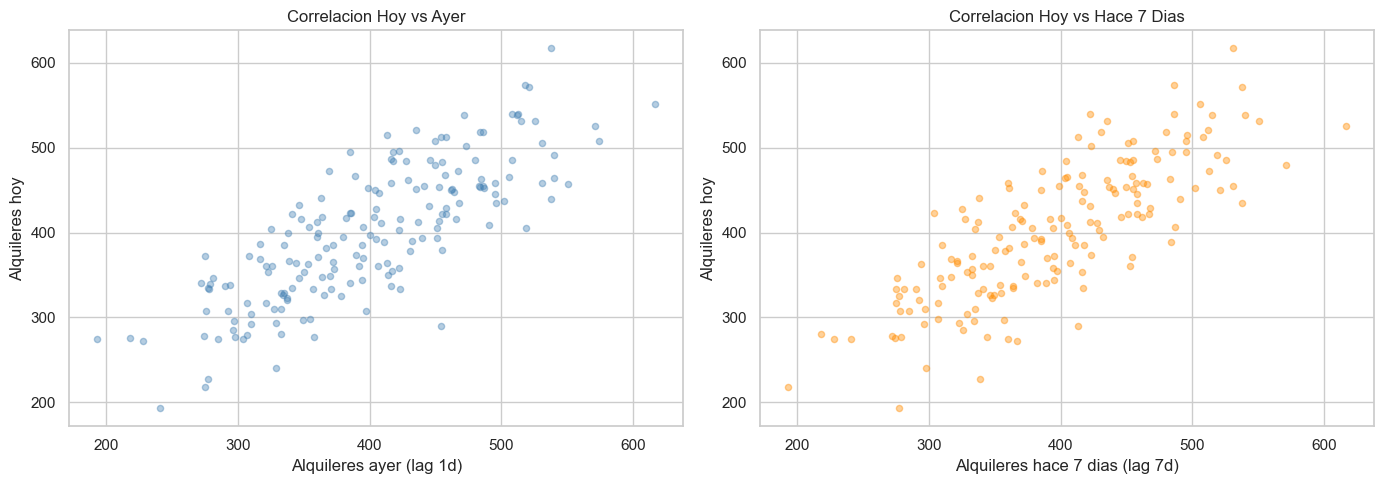

In [4]:
# Visualizar correlacion entre hoy y ayer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['lag_1d'], df['rentals'], alpha=0.4, color='steelblue', s=20)
axes[0].set_xlabel('Alquileres ayer (lag 1d)')
axes[0].set_ylabel('Alquileres hoy')
axes[0].set_title('Correlacion Hoy vs Ayer')

axes[1].scatter(df['lag_7d'], df['rentals'], alpha=0.4, color='darkorange', s=20)
axes[1].set_xlabel('Alquileres hace 7 dias (lag 7d)')
axes[1].set_ylabel('Alquileres hoy')
axes[1].set_title('Correlacion Hoy vs Hace 7 Dias')

plt.tight_layout()
plt.show()

---

## 2. `diff()` — Tasas de cambio

`diff(n)` calcula la diferencia entre el valor actual y el de `n` periodos atrás.  
Elimina tendencias y resalta cambios bruscos.

In [5]:
df['diff_1d'] = df['rentals'].diff(1)   # cambio diario
df['diff_7d'] = df['rentals'].diff(7)   # cambio respecto a la misma semana anterior
df['pct_1d']  = df['rentals'].pct_change(1) * 100  # cambio porcentual diario

print("Primeras filas con diferencias:")
df[['rentals', 'diff_1d', 'diff_7d', 'pct_1d']].head(10).round(2)

Primeras filas con diferencias:


,rentals,diff_1d,diff_7d,pct_1d
2024-01-01,321,NaN,NaN,NaN
2024-01-02,361,40.0,NaN,12.46
2024-01-03,400,39.0,NaN,10.80
2024-01-04,397,-3.0,NaN,-0.75
2024-01-05,307,-90.0,NaN,-22.67
2024-01-06,279,-28.0,NaN,-9.12
2024-01-07,339,60.0,NaN,21.51
2024-01-08,367,28.0,46.0,8.26
2024-01-09,382,15.0,21.0,4.09
2024-01-10,417,35.0,17.0,9.16


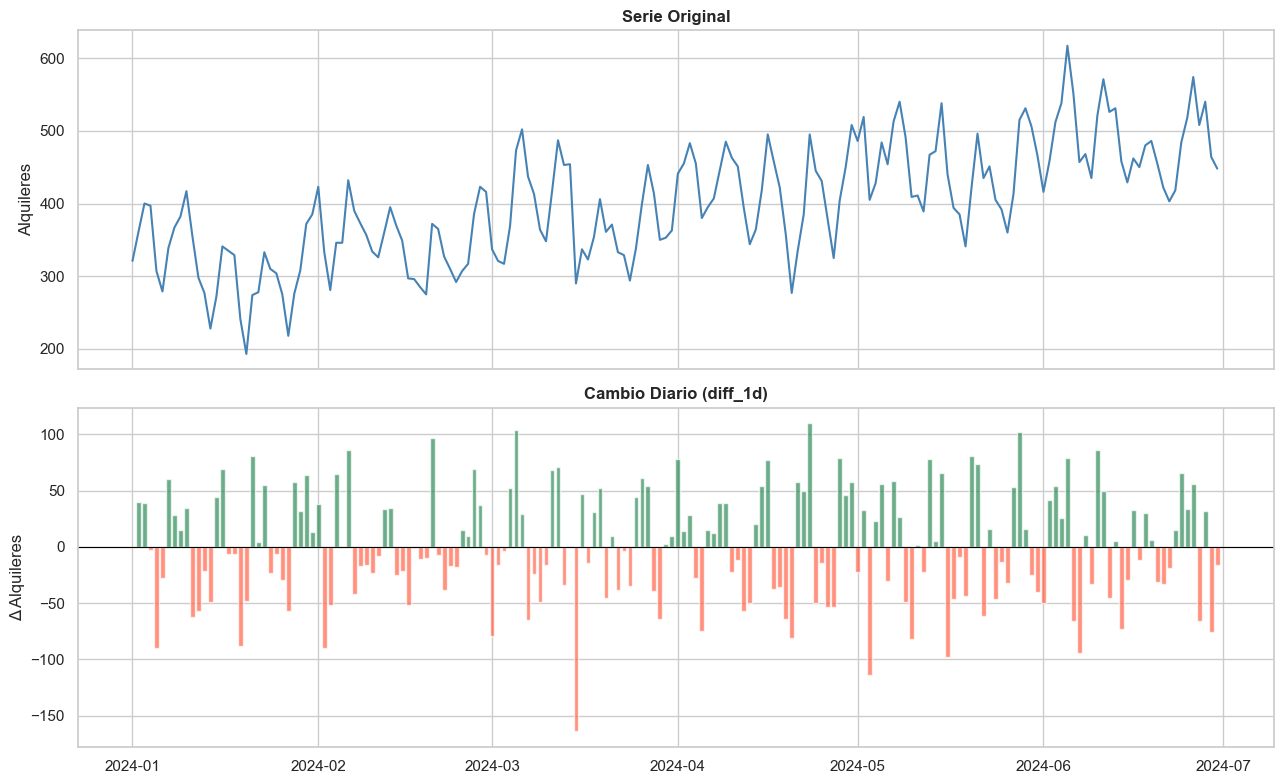

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

axes[0].plot(df.index, df['rentals'], color='steelblue', lw=1.5)
axes[0].set_title('Serie Original', fontweight='bold')
axes[0].set_ylabel('Alquileres')

axes[1].bar(df.index, df['diff_1d'], color=np.where(df['diff_1d'] >= 0, 'seagreen', 'tomato'), alpha=0.7)
axes[1].axhline(0, color='black', lw=0.8)
axes[1].set_title('Cambio Diario (diff_1d)', fontweight='bold')
axes[1].set_ylabel('Δ Alquileres')

plt.tight_layout()
plt.show()

---

## 3. Autocorrelación

La **autocorrelación** mide cuánto se parece la serie a sí misma desplazada en el tiempo.  
Es la herramienta clave para identificar periodicidades (diaria, semanal, mensual...).

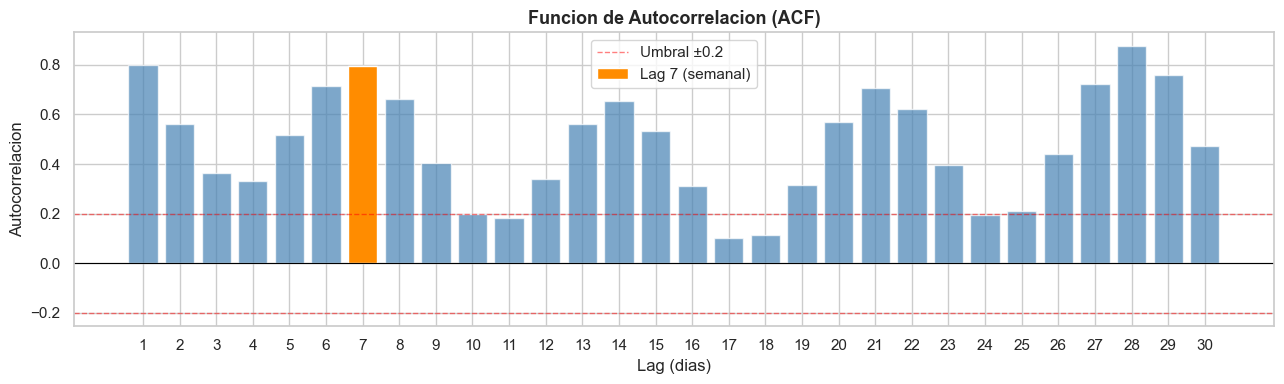

Autocorrelacion lag=7: 0.796


In [7]:
from pandas.plotting import autocorrelation_plot

# Calcular autocorrelacion para distintos lags
lags = range(1, 31)
acf_values = [df['rentals'].autocorr(lag=l) for l in lags]

fig, ax = plt.subplots(figsize=(13, 4))

ax.bar(lags, acf_values, color='steelblue', alpha=0.7)
ax.axhline(0, color='black', lw=0.8)
ax.axhline(0.2,  color='red', lw=1, linestyle='--', alpha=0.5, label='Umbral ±0.2')
ax.axhline(-0.2, color='red', lw=1, linestyle='--', alpha=0.5)

# Marcar el lag 7 (semanal)
ax.bar(7, acf_values[6], color='darkorange', label='Lag 7 (semanal)')

ax.set_title('Funcion de Autocorrelacion (ACF)', fontsize=13, fontweight='bold')
ax.set_xlabel('Lag (dias)')
ax.set_ylabel('Autocorrelacion')
ax.legend()
ax.set_xticks(list(lags))

plt.tight_layout()
plt.show()

print(f"Autocorrelacion lag=7: {acf_values[6]:.3f}")

---

## 4. Descomposición estacional

La descomposición separa la serie en tres componentes independientes:

- **Tendencia (Trend):** dirección a largo plazo
- **Estacionalidad (Seasonal):** patrones que se repiten
- **Residuo (Residual):** ruido o anomalías sin explicar

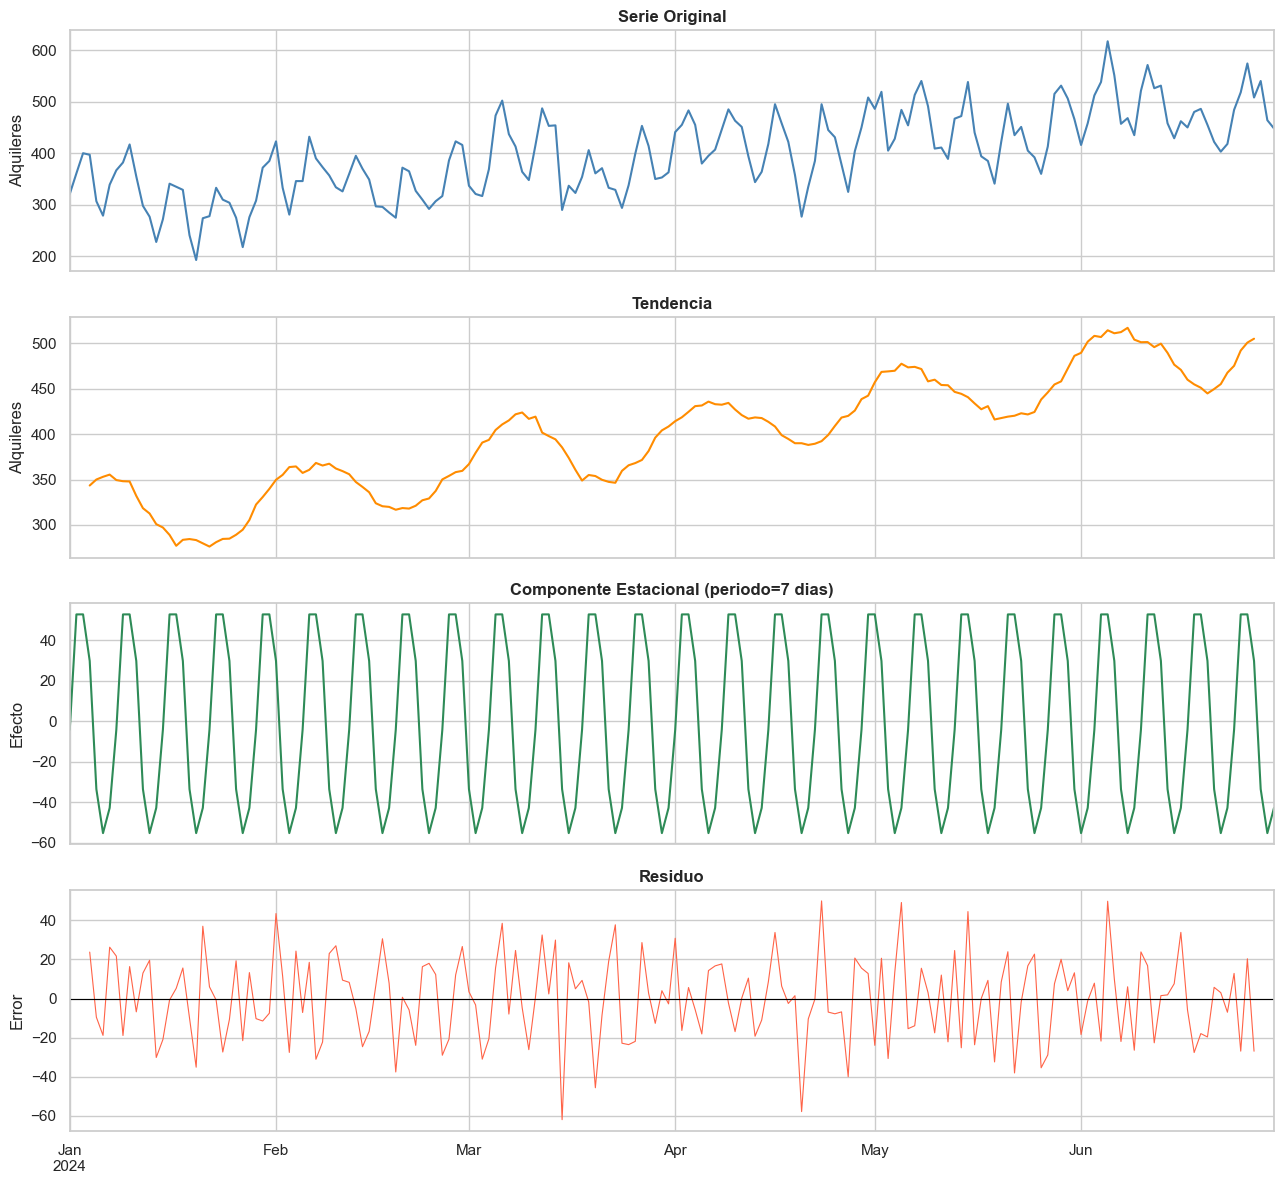

In [8]:
# Descomposicion aditiva: serie = tendencia + estacionalidad + residuo
# period=7 porque nuestra estacionalidad principal es semanal
result = seasonal_decompose(ts, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(13, 12), sharex=True)

result.observed.plot(ax=axes[0], color='steelblue')
axes[0].set_title('Serie Original', fontweight='bold')
axes[0].set_ylabel('Alquileres')

result.trend.plot(ax=axes[1], color='darkorange')
axes[1].set_title('Tendencia', fontweight='bold')
axes[1].set_ylabel('Alquileres')

result.seasonal.plot(ax=axes[2], color='seagreen')
axes[2].set_title('Componente Estacional (periodo=7 dias)', fontweight='bold')
axes[2].set_ylabel('Efecto')

result.resid.plot(ax=axes[3], color='tomato', lw=0.8)
axes[3].axhline(0, color='black', lw=0.8)
axes[3].set_title('Residuo', fontweight='bold')
axes[3].set_ylabel('Error')

plt.tight_layout()
plt.show()

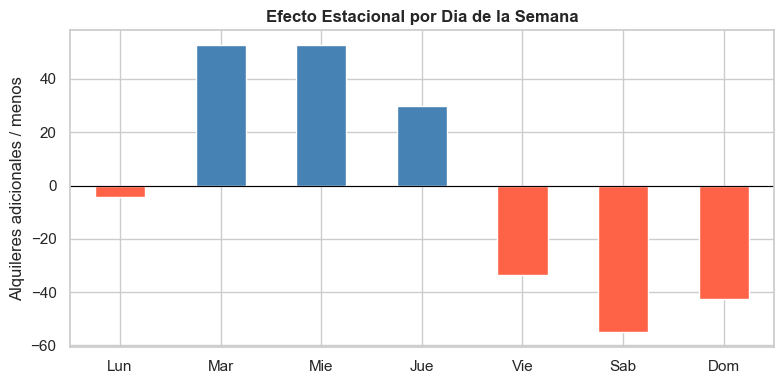

In [9]:
# Analizar el componente estacional semanal
seasonal_week = result.seasonal[:7].copy()
seasonal_week.index = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['steelblue' if v >= 0 else 'tomato' for v in seasonal_week]
seasonal_week.plot(kind='bar', ax=ax, color=colors, edgecolor='white')
ax.axhline(0, color='black', lw=0.8)
ax.set_title('Efecto Estacional por Dia de la Semana', fontweight='bold')
ax.set_ylabel('Alquileres adicionales / menos')
ax.set_xticklabels(seasonal_week.index, rotation=0)
plt.tight_layout()
plt.show()

---

## 5. Ingeniería de características temporales

Convertir la información temporal en columnas numéricas listas para un modelo ML.

In [10]:
fe = df[['rentals']].copy()

# Calendarias
fe['day_of_week']  = fe.index.dayofweek        # 0=Lun, 6=Dom
fe['day_of_month'] = fe.index.day
fe['week_of_year'] = fe.index.isocalendar().week.astype(int)
fe['month']        = fe.index.month
fe['is_weekend']   = (fe.index.dayofweek >= 5).astype(int)

# Lag features
fe['lag_1']  = fe['rentals'].shift(1)
fe['lag_7']  = fe['rentals'].shift(7)
fe['lag_14'] = fe['rentals'].shift(14)

# Rolling features
fe['roll_mean_7']  = fe['rentals'].rolling(7).mean()
fe['roll_std_7']   = fe['rentals'].rolling(7).std()
fe['roll_mean_14'] = fe['rentals'].rolling(14).mean()

# Diferencias
fe['diff_1'] = fe['rentals'].diff(1)
fe['diff_7'] = fe['rentals'].diff(7)

# Encoding ciclico (importante para modelos que no entienden la circularidad)
fe['dow_sin'] = np.sin(2 * np.pi * fe['day_of_week'] / 7)
fe['dow_cos'] = np.cos(2 * np.pi * fe['day_of_week'] / 7)
fe['month_sin'] = np.sin(2 * np.pi * (fe['month'] - 1) / 12)
fe['month_cos'] = np.cos(2 * np.pi * (fe['month'] - 1) / 12)

# Eliminar filas con NaN (por los lags y rolling)
fe = fe.dropna()

print(f"Features generadas: {fe.shape[1] - 1} columnas")
print(f"Filas disponibles: {len(fe)}")
fe.head()

Features generadas: 17 columnas
Filas disponibles: 168


,rentals,day_of_week,day_of_month,week_of_year,month,is_weekend,lag_1,lag_7,lag_14,roll_mean_7,roll_std_7,roll_mean_14,diff_1,diff_7,dow_sin,dow_cos,month_sin,month_cos
2024-01-15,272,0,15,3,1,0,228.0,367.0,321.0,318.428571,67.776243,334.214286,44.0,-95.0,0.000000,1.000000,0.0,1.0
2024-01-16,341,1,16,3,1,0,272.0,382.0,361.0,312.571429,62.967868,332.785714,69.0,-41.0,0.781831,0.623490,0.0,1.0
2024-01-17,335,2,17,3,1,0,341.0,417.0,400.0,300.857143,45.509811,328.142857,-6.0,-82.0,0.974928,-0.222521,0.0,1.0
2024-01-18,329,3,18,3,1,0,335.0,355.0,397.0,297.142857,41.212573,323.285714,-6.0,-26.0,0.433884,-0.900969,0.0,1.0
2024-01-19,241,4,19,3,1,0,329.0,298.0,307.0,289.000000,46.328537,318.571429,-88.0,-57.0,-0.433884,-0.900969,0.0,1.0


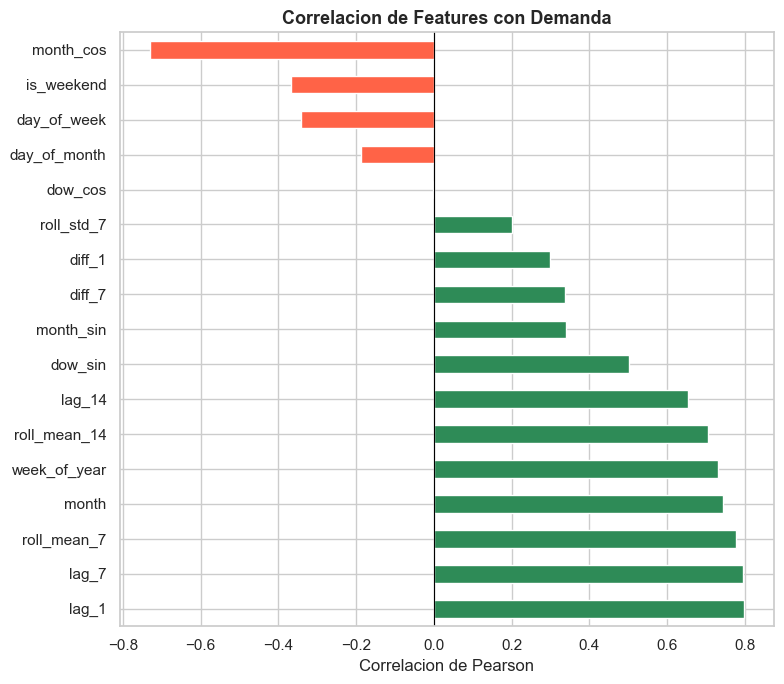

In [11]:
# Correlacion de cada feature con la variable objetivo
corr = fe.corr()['rentals'].drop('rentals').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 7))
colors = ['seagreen' if c > 0 else 'tomato' for c in corr]
corr.plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', lw=0.8)
ax.set_title('Correlacion de Features con Demanda', fontsize=13, fontweight='bold')
ax.set_xlabel('Correlacion de Pearson')
plt.tight_layout()
plt.show()

---

## Resumen

| Técnica | Herramienta | Para qué sirve |
|---------|-------------|----------------|
| Lag features | `shift(n)` | Capturar memoria de la serie |
| Tasa de cambio | `diff(n)` | Eliminar tendencia, detectar cambios |
| Autocorrelación | `autocorr(lag)` | Identificar periodicidades |
| Descomposición | `seasonal_decompose()` | Separar tendencia, estación y ruido |
| Encoding cíclico | `sin/cos` | Representar variables cíclicas para ML |
| Rolling features | `rolling().mean()/.std()` | Contexto local suavizado |

---

## Ejercicio

Entrena un modelo básico de regresión lineal (`sklearn.linear_model.LinearRegression`)  
usando como features: `lag_7`, `roll_mean_7`, `is_weekend`, `dow_sin`, `dow_cos`.  
Evalúa con MAE en un split temporal (últimos 30 días como test).

Train: 138 dias, Test: 30 dias
MAE: 19.5 alquileres


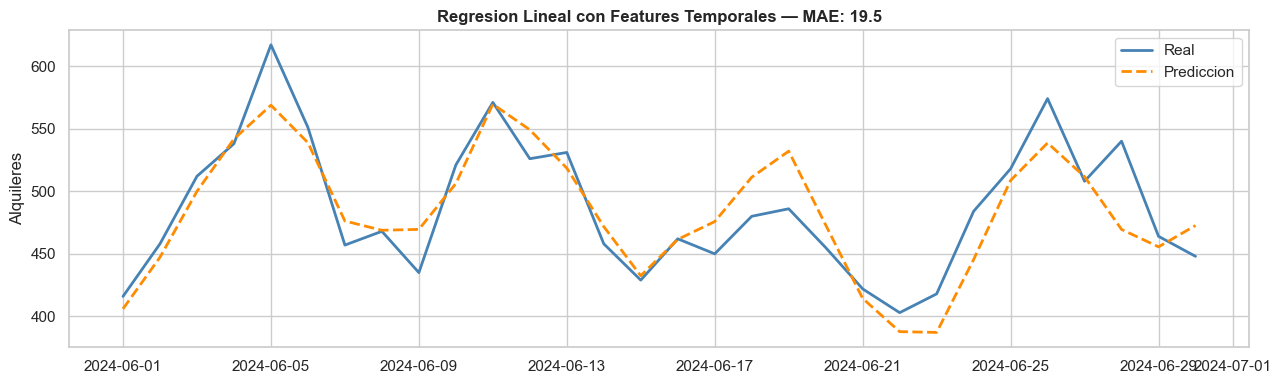

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

FEATURES = ['lag_7', 'roll_mean_7', 'is_weekend', 'dow_sin', 'dow_cos']
TARGET = 'rentals'

# Split temporal: ultimos 30 dias como test
split_date = fe.index[-30]
train = fe[fe.index < split_date]
test  = fe[fe.index >= split_date]

model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

preds = model.predict(test[FEATURES])
mae = mean_absolute_error(test[TARGET], preds)

print(f"Train: {len(train)} dias, Test: {len(test)} dias")
print(f"MAE: {mae:.1f} alquileres")

# Visualizacion
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(test.index, test[TARGET], label='Real', color='steelblue', lw=2)
ax.plot(test.index, preds, label='Prediccion', color='darkorange', lw=2, linestyle='--')
ax.set_title(f'Regresion Lineal con Features Temporales — MAE: {mae:.1f}', fontweight='bold')
ax.set_ylabel('Alquileres')
ax.legend()
plt.tight_layout()
plt.show()

---

**Anterior:** [10.02 - Resampling y Ventanas Deslizantes](./10_02_resampling_rolling.ipynb)  
**Siguiente:** [11.02 - Polars: Foundations](../11_advanced_patterns/11_02_polars_foundations.ipynb)